In [ ]:
# ==========================================
# SCRIPT KOREKSI BIAS: LINEAR REGRESSION
# ==========================================
# Penulis: Jariyan Arifudin
# Metode: Regresi Linear Time-Variant (Per Bulan)
# ==========================================

# 1. INSTALL LIBRARY (JIKA BELUM ADA)
!pip install rasterio geopandas shapely matplotlib scikit-learn pandas numpy seaborn tqdm folium

import os
import glob
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from google.colab import drive
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# ==========================================
# BAGIAN 1: SETUP & KONFIGURASI
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# --- DIREKTORI DATA (SESUAIKAN PATH INI) ---
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi/'
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/')
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CSV_DIR = os.path.join(BASE_DIR, 'Data Stasiun BWS Sumatera VI/')

# Output Directory
output_dir = os.path.join(CHIRPS_DIR, 'bias_corrected_regression')
os.makedirs(output_dir, exist_ok=True)

# Rentang wilayah (Bounding Box Awal untuk memperingan proses)
# Longitude 100.75 - 104.75 | Latitude -2.75 - -0.5 (Area Jambi)
bbox = box(100.75, -2.75, 104.75, -0.5)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# --- DAFTAR STASIUN ---
# 1. Stasiun Kalibrasi (Untuk membentuk Model Regresi)
bias_stations = [
    "Koto Limau Sering", "Semurup", "Sipin", "Siulak Deras",
    "Dendang", "Pulau Tengah", "Tamiai"
]

# 2. Stasiun Validasi (Untuk Menguji Akurasi Model)
validation_stations = [
    "Bukit Bulan",
    "Muara Tembesi",
    "Rantau Pandan",
    "Sungai Manau",
    "Tanjung Genting",
    "Muaro Imat",
    "Sungai Bengkal"
]

# Lokasi Koordinat Stasiun (Longitude/X, Latitude/Y)
station_coords = {
    "Koto Limau Sering": (101.366300, -2.063383),
    "Semurup": (101.378350, -2.001750),
    "Sipin": (103.596750, -1.610600),
    "Siulak Deras": (101.297850, -1.936050),
    "Dendang": (103.948100, -1.190800),
    "Pulau Tengah": (101.463533, -2.169750),
    "Tamiai": (101.643800, -2.186933),
    "Batang Asai": (102.285631, -2.492758),
    "Biuku Tanjung": (102.201683, -2.123467),
    "Bukit Bulan": (102.639417, -2.517517),
    "Hiang": (101.477800, -2.074217),
    "Jujuhan": (101.766217, -1.328300),
    "Kersik Tuo": (101.282533, -1.779867),
    "Pulau Musang": (102.100717, -1.157717),
    "Mess Bungo": (102.330650, -1.494717),
    "Muara Jernih": (102.166800, -1.950067),
    "Muara Tembesi": (103.127017, -1.719333),
    "Pulau Lintang": (102.592700, -2.280883),
    "Rantau Pandan": (101.968817, -1.621217),
    "Rimbo Bujang": (102.088833, -1.319517),
    "Senamat": (102.330650, -1.643583),
    "Suak Kandis": (104.053117, -1.374000),
    "Sungai Manau": (101.983400, -2.114817),
    "Tanjung Genting": (103.161200, -1.938300),
    "Durian Luncuk": (102.995683, -1.880150),
    "Gapura Suci": (102.285383, -1.699950),
    "Lempur": (101.627683, -2.248867),
    "Muaro Imat": (101.719850, -2.225333),
    "Pamenang": (102.512817, -2.112200),
    "Pasir Putih": (103.643200, -1.622550),
    "Pauh": (102.820633, -2.133417),
    "Sungai Bengkal": (102.723933, -1.550633),
    "Singkut": (102.713633, -2.506200)
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==========================================
# BAGIAN 2: FUNGSI UTILITAS
# ==========================================

def clip_raster_to_bbox(input_path, bbox_geom):
    """Memotong raster sesuai kotak pembatas (bbox)"""
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, bbox_geom.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

def extract_chirps_at_point(raster, transform, lon, lat):
    """Mengambil nilai piksel raster berdasarkan koordinat Lat/Lon"""
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    try:
        val = raster[row, col]
        return val if val != -9999 else np.nan
    except IndexError:
        return np.nan

def load_station_csv(csv_dir):
    """Membaca data stasiun dan mengubahnya menjadi format Time Series"""
    bulan_mapping = {'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
                     'Mei': '05', 'Juni': '06', 'Juli': '07', 'Agustus': '08',
                     'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'}
    station_data = {}
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

    if not csv_files:
        print("[ERROR] Tidak ada file CSV ditemukan di direktori stasiun!")
        return {}

    for csv_file in csv_files:
        nama = os.path.basename(csv_file).replace('.csv', '')
        try:
            df = pd.read_csv(csv_file, index_col=0)
            df.replace("-", np.nan, inplace=True)
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.stack().reset_index()
            df.columns = ['Bulan', 'Tahun', 'CurahHujan']
            df['BulanAngka'] = df['Bulan'].map(bulan_mapping)
            df['Tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + "-" + df['BulanAngka'] + "-01")
            df.set_index('Tanggal', inplace=True)
            station_data[nama] = df[['CurahHujan']].sort_index()
        except Exception as e:
            print(f"[WARNING] Gagal membaca {nama}: {e}")

    return station_data

In [ ]:
# ==========================================
# BAGIAN 3: PROSES UTAMA (LOOPING & KOREKSI)
# ==========================================

# Load Data
print("--- Memuat Data ---")
station_data = load_station_csv(CSV_DIR)
chirps_files = sorted(glob.glob(os.path.join(CHIRPS_DIR, 'chirps-v3.0.*.tif')))
validasi_df = pd.DataFrame()

print(f"Total file CHIRPS ditemukan: {len(chirps_files)}")

# Loop File Raster (Per Bulan)
for file_path in tqdm(chirps_files, desc="Proses Koreksi Regresi"):
    filename = os.path.basename(file_path)

    # Parsing tanggal
    try:
        parts = filename.split('.')
        date_str = f"{parts[2]}-{parts[3]}-01"
        date = pd.to_datetime(date_str)
    except IndexError:
        continue

    # 1. Baca raster & klip area studi
    try:
        raster, meta = clip_raster_to_bbox(file_path, bbox_gdf)
    except Exception as e:
        print(f"Error reading raster {filename}: {e}")
        continue

    # 2. TRAINING: Ambil data pasangan (Satelit vs Obs) di Stasiun Kalibrasi
    X_sat = []
    y_obs = []

    for stasiun in bias_stations:
        if stasiun in station_data:
            # Ambil data curah hujan observasi pada bulan tersebut
            try:
                obs_val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]

                if not np.isnan(obs_val):
                    lon, lat = station_coords[stasiun]
                    sat_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)

                    # Pastikan sat_val valid (bukan NaN dan tidak negatif)
                    if not np.isnan(sat_val) and sat_val >= 0:
                        X_sat.append(sat_val)
                        y_obs.append(obs_val)
            except KeyError:
                continue

    # 3. MEMBUAT MODEL REGRESI (Y = aX + b)
    # Model dibuat KHUSUS untuk bulan ini saja (Time-Variant)
    if len(X_sat) >= 2: # Butuh minimal 2 titik untuk buat garis
        X_train = np.array(X_sat).reshape(-1, 1)
        y_train = np.array(y_obs)

        model = LinearRegression()
        model.fit(X_train, y_train)

        slope = model.coef_[0]      # Gradien (a)
        intercept = model.intercept_ # Konstanta (b)

        # Terapkan rumus ke seluruh raster: CHIRPS_Corrected = (Slope * CHIRPS_Raw) + Intercept
        corrected_raster = intercept + (slope * raster)

        # PENTING: Cegah nilai negatif akibat intercept negatif
        corrected_raster = np.maximum(corrected_raster, 0)
    else:
        # Jika data stasiun tidak cukup bulan ini, biarkan data asli (tanpa koreksi)
        corrected_raster = raster
        slope, intercept = 1, 0

    # 4. SIMPAN RASTER TERKOREKSI (Opsional, aktifkan jika perlu file .tif)
    # meta.update(dtype='float32')
    # outname = f'chirps-v3.0.{date.year:04d}.{date.month:02d}.reg_corrected.tif'
    # outpath = os.path.join(output_dir, outname)
    # with rasterio.open(outpath, 'w', **meta) as dst:
    #     dst.write(corrected_raster.astype('float32'), 1)

    # 5. VALIDASI: Cek akurasi di Stasiun Validasi
    for stasiun in validation_stations:
        obs_val = np.nan
        raw_val = np.nan
        corr_val = np.nan

        # Ambil data Observasi
        if stasiun in station_data:
            try:
                val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                if not np.isnan(val):
                    obs_val = val
            except:
                pass

        # Ambil data Satelit (Raw & Corrected)
        if stasiun in station_coords:
            lon, lat = station_coords[stasiun]
            raw_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)
            corr_val = extract_chirps_at_point(corrected_raster, meta['transform'], lon, lat)

        # Simpan ke tabel validasi jika ada data
        if not (np.isnan(obs_val) and np.isnan(raw_val)):
            entry = pd.DataFrame([{
                "Stasiun": stasiun,
                "Tanggal": date,
                "Observed": obs_val,
                "Raw": raw_val,
                "Corrected": corr_val,
                "Slope_Model": slope,
                "Intercept_Model": intercept
            }])
            validasi_df = pd.concat([validasi_df, entry], ignore_index=True)

# Simpan Data Mentah Validasi
validasi_df.sort_values(['Stasiun', 'Tanggal'], inplace=True)
validasi_df.to_csv(os.path.join(output_dir, 'validasi_regresi_raw.csv'), index=False)
print("Looping selesai.")

--- Memuat Data ---
Total file CHIRPS ditemukan: 144


Proses Koreksi Regresi: 100%|██████████| 144/144 [00:38<00:00,  3.74it/s]

Looping selesai.


In [ ]:
# ==========================================
# BAGIAN 4: HITUNG METRIK STATISTIK (NSE, R, RSR)
# ==========================================

print("\n--- Menghitung Indikator Statistik ---")

final_metrics = []

for stasiun in validation_stations:
    subset = validasi_df[validasi_df['Stasiun'] == stasiun]

    # Siapkan variabel penampung
    stats = {
        "Stasiun": stasiun,
        "NSE_Raw": np.nan, "NSE_Corrected": np.nan,
        "R_Raw": np.nan, "R_Corrected": np.nan,
        "RSR_Raw": np.nan, "RSR_Corrected": np.nan
    }

    if not subset.empty:
        obs = subset["Observed"].values
        raw = subset["Raw"].values
        corr = subset["Corrected"].values

        # Masking (hanya ambil data yang lengkap pasangan obs-satelit)
        mask_raw = ~np.isnan(obs) & ~np.isnan(raw)
        mask_corr = ~np.isnan(obs) & ~np.isnan(corr)

        # Fungsi Hitung Statistik
        def calculate_metrics(o, p):
            if len(o) < 2: return np.nan, np.nan, np.nan

            # 1. Pearson Correlation (R)
            r_val, _ = pearsonr(o, p)

            # 2. NSE
            # NSE = 1 - (Sum(Obs-Sim)^2 / Sum(Obs-MeanObs)^2)
            numerator = np.sum((o - p)**2)
            denominator = np.sum((o - np.mean(o))**2)
            nse = 1 - (numerator / denominator) if denominator != 0 else np.nan

            # 3. RSR
            # RSR = RMSE / Stdev_Obs
            rmse = np.sqrt(mean_squared_error(o, p))
            stdev = np.std(o)
            rsr = rmse / stdev if stdev != 0 else np.nan

            return nse, r_val, rsr

        # Hitung Raw
        stats["NSE_Raw"], stats["R_Raw"], stats["RSR_Raw"] = calculate_metrics(obs[mask_raw], raw[mask_raw])
        # Hitung Corrected
        stats["NSE_Corrected"], stats["R_Corrected"], stats["RSR_Corrected"] = calculate_metrics(obs[mask_corr], corr[mask_corr])

    final_metrics.append(stats)

# Buat Tabel Ringkasan
summary = pd.DataFrame(final_metrics)
print("\nRingkasan Validasi Statistik (Sampel 5 Baris):")
print(summary.head().to_string())

# Simpan Hasil Akhir
summary.to_csv(os.path.join(output_dir, 'Hasil_Validasi_NSE_R_RSR.csv'), index=False)
print(f"\nFile tersimpan di: {os.path.join(output_dir, 'Hasil_Validasi_NSE_R_RSR.csv')}")


--- Menghitung Indikator Statistik ---

Ringkasan Validasi Statistik (Sampel 5 Baris):
           Stasiun   NSE_Raw  NSE_Corrected     R_Raw  R_Corrected   RSR_Raw  RSR_Corrected
0      Bukit Bulan  0.052189      -0.568227  0.491433     0.339534  0.973556       1.252289
1    Muara Tembesi -5.723833      -4.413970  0.542688     0.430993  2.593036       2.326794
2    Rantau Pandan  0.106813      -0.251999  0.564325     0.338155  0.945086       1.118927
3     Sungai Manau -0.350546      -0.678501  0.368643     0.196948  1.162130       1.295570
4  Tanjung Genting -0.706896      -1.015058  0.407449     0.267949  1.306482       1.419527

File tersimpan di: /content/drive/My Drive/Colab Notebooks/Skripsi/CHIRPS v3/bias_corrected_regression/Hasil_Validasi_NSE_R_RSR.csv


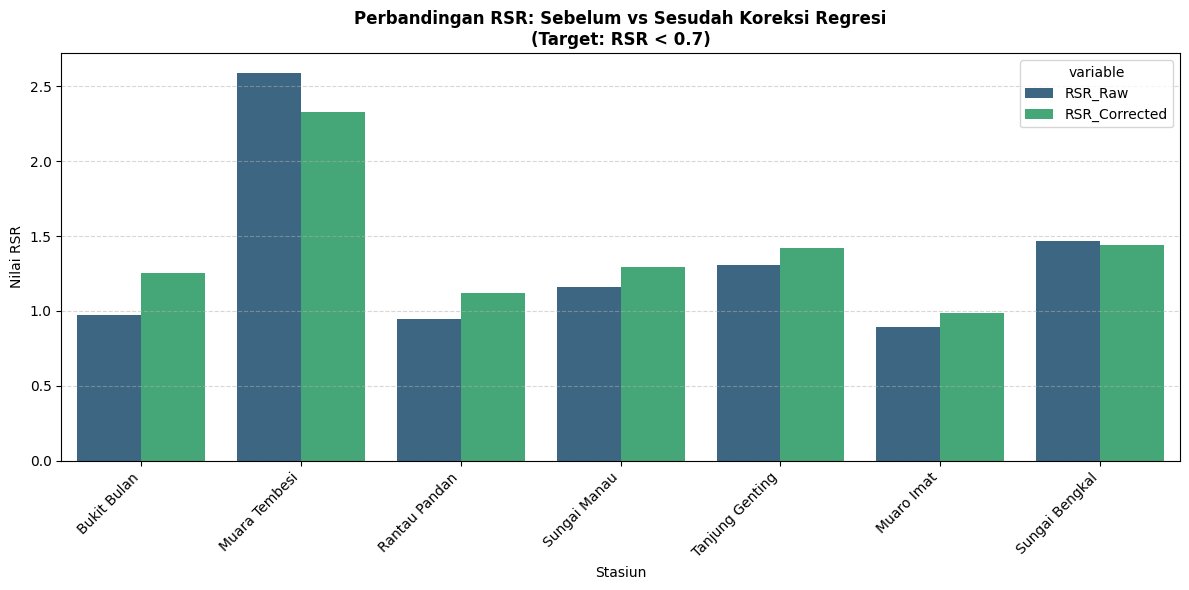

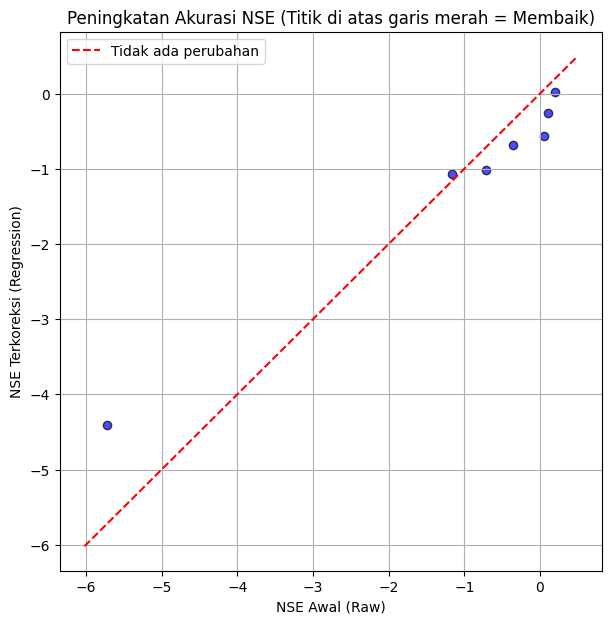

In [ ]:
# ==========================================
# BAGIAN 5: VISUALISASI
# ==========================================

# Grafik 1: Perbandingan RSR (Semakin rendah bar, semakin baik)
plt.figure(figsize=(12, 6))
plot_data = summary.melt(id_vars='Stasiun', value_vars=['RSR_Raw', 'RSR_Corrected'])
sns.barplot(data=plot_data, x='Stasiun', y='value', hue='variable', palette='viridis')
plt.title('Perbandingan RSR: Sebelum vs Sesudah Koreksi Regresi\n(Target: RSR < 0.7)', fontweight='bold')
plt.ylabel('Nilai RSR')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Grafik 2: Scatter Plot NSE
plt.figure(figsize=(7, 7))
plt.scatter(summary['NSE_Raw'], summary['NSE_Corrected'], alpha=0.7, c='blue', edgecolors='k')
# Garis 1:1
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()])
]
plt.plot(lims, lims, 'r--', label='Tidak ada perubahan')
plt.xlabel('NSE Awal (Raw)')
plt.ylabel('NSE Terkoreksi (Regression)')
plt.title('Peningkatan Akurasi NSE (Titik di atas garis merah = Membaik)')
plt.legend()
plt.grid(True)
plt.show()